# FUNNEL ANALYSIS

In [6]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import calendar

In [14]:
from google.analytics.data_v1beta import FilterExpression
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Metric,
    RunReportRequest,
    OrderBy,
    FilterExpression,
     FilterExpressionList,
     Filter,
)

In [8]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'service_account.json'
property_id = '468166589'

client = BetaAnalyticsDataClient()

In [32]:
# Create multiple filters for each event name
event_filters = [
    Filter(
        field_name="eventName",
        string_filter=Filter.StringFilter(
            match_type=Filter.StringFilter.MatchType.EXACT,  # Ensure exact matches
            value=event  
        )
    ) for event in ["session_start", "home_screen", "quran_start_screen", "ad_impression", "quran_surah_screen"]
]

# Combine them using OR logic
dimension_filter = FilterExpression(
    or_group=FilterExpressionList(expressions=[FilterExpression(filter=f) for f in event_filters])
)


request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="eventName"), ],
        metrics=[Metric(name="eventCount")],
        date_ranges=[DateRange(start_date="2025-01-01", end_date="today")],
    
    dimension_filter= dimension_filter
    )

# Fetch the response
response = client.run_report(request)


In [33]:

# Convert response to DataFrame
data = []
for row in response.rows:
    data.append([row.dimension_values[0].value, int(row.metric_values[0].value)])

df = pd.DataFrame(data, columns=["event", "count"])
df

,event,count
0,session_start,59573
1,home_screen,56072
2,ad_impression,31302
3,quran_surah_screen,27871
4,quran_start_screen,26634


In [40]:
# Ensure data is sorted in the correct funnel order
funnel_order = ["session_start", "home_screen", "ad_impression" , "quran_surah_screen", "quran_start_screen"]
df = df.set_index("event").reindex(funnel_order).reset_index()

# Calculate drop-off rates
df["dropoff"] = df["count"].diff(-1).abs()  # Users lost at each step
df["dropoff_percent"] = df["dropoff_percent"].map(lambda x: f"{x:.2f}%")

df.fillna(0, inplace=True)  # Replace NaN values with 0
df


,event,count,dropoff,dropoff_percent
0,session_start,59573,3501.0,5.88%
1,home_screen,56072,24770.0,44.18%
2,ad_impression,31302,3431.0,10.96%
3,quran_surah_screen,27871,1237.0,4.44%
4,quran_start_screen,26634,0.0,0.00%


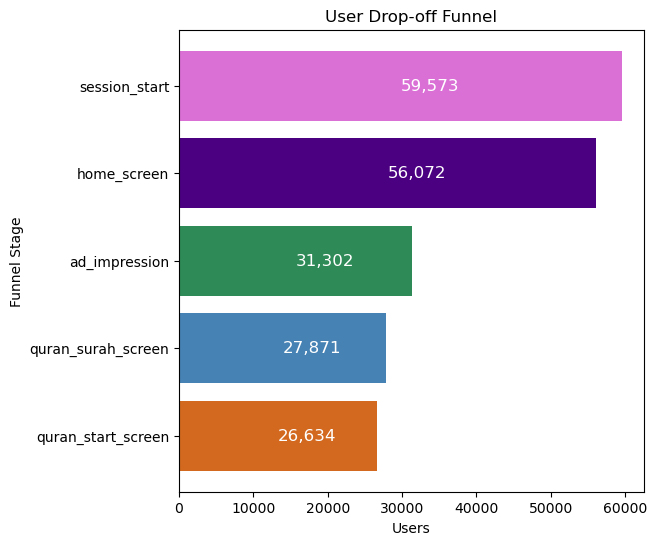

In [60]:
import matplotlib.pyplot as plt

# Define funnel stage names and values
stages = df["event"]
values = df["count"]

# Plot funnel
plt.figure(figsize=(6, 6))
plt.barh(stages[::-1], values[::-1], color=['chocolate', 'steelblue', 'seagreen', 'indigo', 'orchid'])

# Add text labels
for index, value in enumerate(values[::-1]):
    plt.text(value - (value * 0.5), index, f"{value:,}", va="center", fontsize=12, color="white")

plt.xlabel("Users")
plt.ylabel("Funnel Stage")
plt.title("User Drop-off Funnel")
plt.show()
